# Real Estate Pricing Tier Classification 
Names: Thai, Laxmi, and Daniel

## Introduction
The real estate market is a dynamic and complex environment where property values fluctuate due to a myriad of factors. Our final project aims to demystify this volatility by developing a predictive model that can accurately classify properties into distinct price tiers. By analyzing a comprehensive dataset of real estate transactions, we intend to uncover patterns and indicators that influence pricing, thereby providing valuable insights for buyers, sellers, and investors alike. This endeavor not only seeks to enhance market transparency but also to empower stakeholders with a tool for informed decision-making in the real estate domain.

### Dataset

The dataset comprises over 4 million entries of U.S. real estate listings, segmented by state and zip code, sourced from Realtor.com, a leading property listing platform. It encompasses a comprehensive range of data points including housing status, number of bedrooms and bathrooms, land size in acres, city, state, postal code, living space in square feet, previous sale date, and the listing or recently sold price. This rich dataset provides a granular view of the current real estate market, offering valuable insights for various analyses and applications.

Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset/data


### Packages

In [98]:
# Install necessary packages (if not already installed)
!pip install pandas numpy matplotlib scikit-learn kaggle scipy

# Import required libraries
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency

# Print a success message
print("All necessary packages are installed and imported successfully.")

All necessary packages are installed and imported successfully.


## Exploratory Data Analysis

### Data collection

#### Pre-requisites
To download the dataset, please follow the below steps:
1. Create a Kaggle account
2. After logging in, go to your user settings page on Kaggle.
3. Click the “Create New Token” button.
4. This action will download a file named kaggle.json to your computer.
5. Copy this file to the directory 'C:\Users\<your_username>\.kaggle'

In [ ]:
# After ensuring you’ve met the prerequisites, execute the following command to download the dataset
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

with zipfile.ZipFile("usa-real-estate-dataset.zip","r") as zip_ref:
    
    # extracting content in the zipfile
    zip_ref.extractall()


In [66]:
# Load the dataset
df = pd.read_csv('realtor-data.zip.csv')

# Inspect the data
print(df.head())
print(df.info())

     status  bed  bath  acre_lot        city        state  zip_code  \
0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size prev_sold_date     price  
0       920.0            NaN  105000.0  
1      1527.0            NaN   80000.0  
2       748.0            NaN   67000.0  
3      1800.0            NaN  145000.0  
4         NaN            NaN   65000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4069420 entries, 0 to 4069419
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   status          object 
 1   bed             float64
 2   bath            float64
 3   acre_lot        float64
 4   city            object 
 5   state 

### Data cleaning

In [67]:
# Remove columns that are irrelavant
df.drop(['status', 'prev_sold_date', 'zip_code'], axis=1, inplace=True)

# Handle missing values for numerical columns by imputing with the median
numerical_columns = ['bed', 'bath', 'acre_lot', 'house_size', 'price']
df[numerical_columns] = df[numerical_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# Assuming 'city' and 'state' are the only categorical columns with missing values
# Handle missing values for categorical columns by imputing with the mode (most common value)
categorical_columns = ['city', 'state']
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Display all unique values in the 'state' column
print("\nAll states (Including New Brunswick, Puerto Rico, and Virgin Islands):")
print(df['state'].unique())

# Define the list of states to delete
delete_states = ['New Brunswick', 'Puerto Rico', 'Virgin Islands']

# Filter the DataFrame to keep only rows where the 'state' column does not belong to the states to delete
df = df[~df['state'].isin(delete_states)]

# Display USA states only in the 'state' column
print("\nUSA states only:")
print(df['state'].unique())

# Recheck info
print(df.info())

# Save the cleaned dataset
df.to_csv('clean-realtor-data.zip.csv', index=False)


All states (Including New Brunswick, Puerto Rico, and Virgin Islands):
['Puerto Rico' 'Virgin Islands' 'Massachusetts' 'Connecticut'
 'New Hampshire' 'Vermont' 'New Jersey' 'New York' 'South Carolina'
 'Tennessee' 'Rhode Island' 'Virginia' 'Wyoming' 'Maine' 'Georgia'
 'Pennsylvania' 'West Virginia' 'Delaware' 'Louisiana' 'Ohio' 'California'
 'Colorado' 'Maryland' 'Missouri' 'District of Columbia' 'Wisconsin'
 'North Carolina' 'Kentucky' 'Michigan' 'Mississippi' 'Florida' 'Alabama'
 'New Brunswick' 'Texas' 'Arkansas']

USA states only:
['Massachusetts' 'Connecticut' 'New Hampshire' 'Vermont' 'New Jersey'
 'New York' 'South Carolina' 'Tennessee' 'Rhode Island' 'Virginia'
 'Wyoming' 'Maine' 'Georgia' 'Pennsylvania' 'West Virginia' 'Delaware'
 'Louisiana' 'Ohio' 'California' 'Colorado' 'Maryland' 'Missouri'
 'District of Columbia' 'Wisconsin' 'North Carolina' 'Kentucky' 'Michigan'
 'Mississippi' 'Florida' 'Alabama' 'Texas' 'Arkansas']
<class 'pandas.core.frame.DataFrame'>
Index: 4042166 e

#### Define Pricing Tier

In [68]:
# Explore Established Pricing Tier
# Define classification criteria for residential properties
def classify_property(price):
    if price <= 300000:
        return 'Starter Homes (Tier 1)'
    elif price <= 500000:
        return 'Family-Friendly Homes (Tier 2)'
    elif price <= 1000000:
        return 'Executive Properties (Tier 3)'
    else:
        return 'Luxury Estates (Tier 4)'

# Apply classification criteria to create 'Property Tier' column
df['Property Tier'] = df['price'].apply(classify_property)

# Reorder the categories in the 'Property Tier' column
df['Property Tier'] = pd.Categorical(df['Property Tier'], categories=[
    'Starter Homes (Tier 1)',
    'Family-Friendly Homes (Tier 2)',
    'Executive Properties (Tier 3)',
    'Luxury Estates (Tier 4)'
], ordered=True)

# Summary of classification criteria
print("\nClassification Criteria for Residential Properties:")
print("Starter Homes (Tier 1): Affordable options below $300,000, ideal for first-time homebuyers or those on a budget.")
print("Family-Friendly Homes (Tier 2): Mid-range properties between $300,001 and $500,000, suitable for families.")
print("Executive Properties (Tier 3): Upscale living between $500,001 and $1,000,000, featuring modern amenities.")
print("Luxury Estates (Tier 4): High-end properties above $1,000,000, offering expansive living spaces and premium finishes.")


Classification Criteria for Residential Properties:
Starter Homes (Tier 1): Affordable options below $300,000, ideal for first-time homebuyers or those on a budget.
Family-Friendly Homes (Tier 2): Mid-range properties between $300,001 and $500,000, suitable for families.
Executive Properties (Tier 3): Upscale living between $500,001 and $1,000,000, featuring modern amenities.
Luxury Estates (Tier 4): High-end properties above $1,000,000, offering expansive living spaces and premium finishes.


#### Remove Duplicate Rows

In [69]:
# Remove duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())
df_filtered = df.copy()
df_filtered.drop_duplicates(inplace=True)
print('Number of duplicate rows after removal: ', df_filtered.duplicated().sum())

Number of duplicate rows:  3447641
Number of duplicate rows after removal:  0


#### Check for Missing Values

In [70]:
# Check for missing values (null)
df_filtered.isnull().sum()

bed              0
bath             0
acre_lot         0
city             0
state            0
house_size       0
price            0
Property Tier    0
dtype: int64

In [71]:
# Check for missing values (na)
df_filtered.isna().sum()

bed              0
bath             0
acre_lot         0
city             0
state            0
house_size       0
price            0
Property Tier    0
dtype: int64

### Descriptive Statistics

In [78]:
# Summary statistics for numerical columns
df_filtered.describe()

,bed,bath,acre_lot,house_size,price
count,594525.000000,594525.000000,594525.000000,5.945250e+05,5.945250e+05
mean,3.241258,2.439346,14.424092,2.020511e+03,5.853117e+05
std,1.453697,1.295316,796.932806,1.311849e+04,3.389487e+06
min,1.000000,1.000000,0.000000,4.000000e+00,0.000000e+00
25%,3.000000,2.000000,0.210000,1.531000e+03,1.599000e+05
50%,3.000000,2.000000,0.330000,1.760000e+03,3.265400e+05
75%,4.000000,3.000000,0.970000,2.100000e+03,5.599000e+05
max,473.000000,212.000000,100000.000000,9.842382e+06,2.147484e+09


In [79]:
# Summary statistics for categorical columns
df_filtered.describe(include = ['object', 'category'])

,city,state,Property Tier
count,594525,594525,594525
unique,8710,32,4
top,Philadelphia,Florida,Starter Homes (Tier 1)
freq,7751,148116,277773


In [80]:
# Counts of unique values in descending order
df_filtered.value_counts()

bed    bath   acre_lot  city                state           house_size  price     Property Tier                 
1.0    1.0    0.00      Allamuchy Township  New Jersey      1760.0      165000.0  Starter Homes (Tier 1)            1
3.0    3.0    0.33      Jackson             New Hampshire   2343.0      425000.0  Family-Friendly Homes (Tier 2)    1
                        Jacksonville        Florida         1308.0      247990.0  Starter Homes (Tier 1)            1
                                                                        253990.0  Starter Homes (Tier 1)            1
                                                                        254990.0  Starter Homes (Tier 1)            1
                                                                                                                   ..
       2.0    0.33      Camden Wyoming      Delaware        2480.0      556900.0  Executive Properties (Tier 3)     1
                        Cameron             North Carolina  1

In [82]:
# Counts of unique values in descending order for original dataset
df.value_counts()

bed  bath  acre_lot  city        state          house_size  price     Property Tier                 
3.0  2.0   0.34      Vienna      Georgia        1760.0      152469.0  Starter Homes (Tier 1)            753
     3.0   0.33      Morgantown  West Virginia  1821.0      295000.0  Starter Homes (Tier 1)            291
     2.0   0.23      Palm Bay    Florida        1760.0      35000.0   Starter Homes (Tier 1)            261
1.0  1.0   0.33      New York    New York       1760.0      499000.0  Family-Friendly Homes (Tier 2)    243
3.0  3.0   0.33      Morgantown  West Virginia  1940.0      280000.0  Starter Homes (Tier 1)            234
                                                                                                       ... 
     2.0   0.21      Plantation  Florida        1363.0      499000.0  Family-Friendly Homes (Tier 2)      1
           0.65      Prattville  Alabama        1760.0      54494.0   Starter Homes (Tier 1)              1
2.0  2.0   0.14      Key Largo   Fl

### Data Visualization

#### Outlier Detection

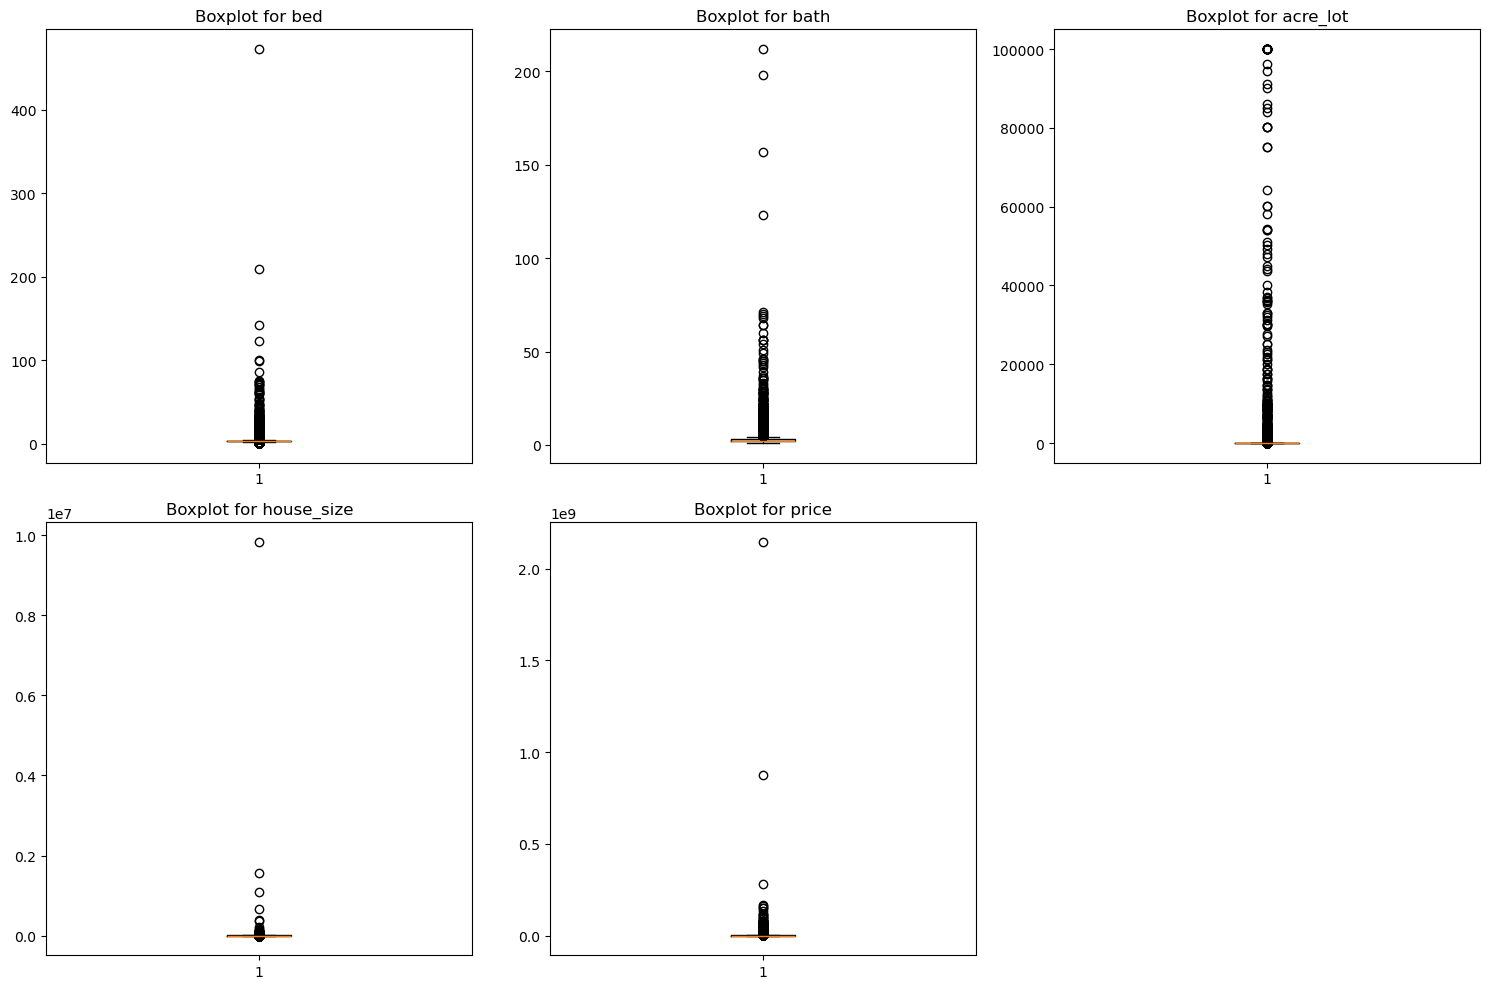

In [83]:
# Check for outliers with boxplot for numerical columns

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot data on the first 5 subplots
axs[0, 0].boxplot(df_filtered[numerical_columns[0]])
axs[0, 0].set_title(f'Boxplot for {numerical_columns[0]}')

axs[0, 1].boxplot(df_filtered[numerical_columns[1]])
axs[0, 1].set_title(f'Boxplot for {numerical_columns[1]}')

axs[0, 2].boxplot(df_filtered[numerical_columns[2]])
axs[0, 2].set_title(f'Boxplot for {numerical_columns[2]}')

axs[1, 0].boxplot(df_filtered[numerical_columns[3]])
axs[1, 0].set_title(f'Boxplot for {numerical_columns[3]}')

axs[1, 1].boxplot(df_filtered[numerical_columns[4]])
axs[1, 1].set_title(f'Boxplot for {numerical_columns[4]}')

# Remove the last (empty) subplot
fig.delaxes(axs[1][2])

# Display the figure with subplots
plt.tight_layout()
plt.show()

In [84]:
# Remove outliers for numerical columns

# Print total number of rows in filtered dataframe
print(f'Total rows with outliers : {df_filtered.shape[0]}')

# Copy dataframe
df_no_outliers = df_filtered.copy()

# Loop through numerical columns
for col in numerical_columns:
    # Calculate IQR
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    # Print total number of rows after removal of outliers
    print(f'Total rows with out outliers for column {col} : {df_no_outliers.shape[0]}')

Total rows with outliers : 594525
Total rows with out outliers for column bed : 553415
Total rows with out outliers for column bath : 535124
Total rows with out outliers for column acre_lot : 453428
Total rows with out outliers for column house_size : 415517
Total rows with out outliers for column price : 391150


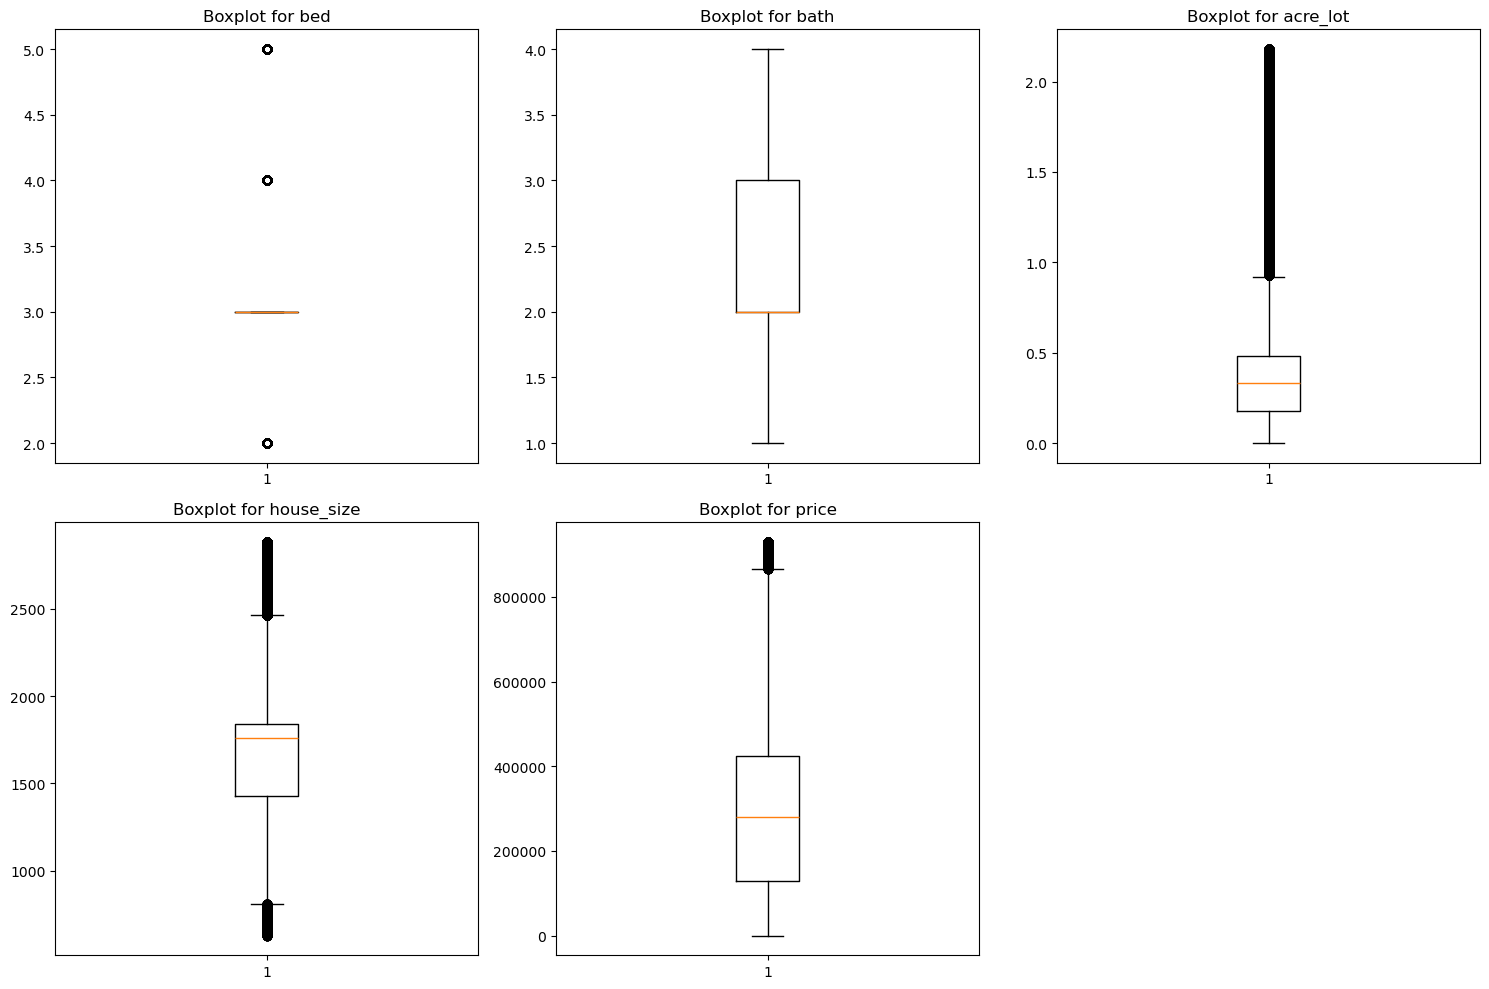

In [85]:
# Plot boxplots after removal of outliers from numerical columns

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot data on the first 5 subplots
axs[0, 0].boxplot(df_no_outliers[numerical_columns[0]])
axs[0, 0].set_title(f'Boxplot for {numerical_columns[0]}')

axs[0, 1].boxplot(df_no_outliers[numerical_columns[1]])
axs[0, 1].set_title(f'Boxplot for {numerical_columns[1]}')

axs[0, 2].boxplot(df_no_outliers[numerical_columns[2]])
axs[0, 2].set_title(f'Boxplot for {numerical_columns[2]}')

axs[1, 0].boxplot(df_no_outliers[numerical_columns[3]])
axs[1, 0].set_title(f'Boxplot for {numerical_columns[3]}')

axs[1, 1].boxplot(df_no_outliers[numerical_columns[4]])
axs[1, 1].set_title(f'Boxplot for {numerical_columns[4]}')

# Remove the last (empty) subplot
fig.delaxes(axs[1][2])

# Display the figure with subplots
plt.tight_layout()
plt.show()

#### Visualization

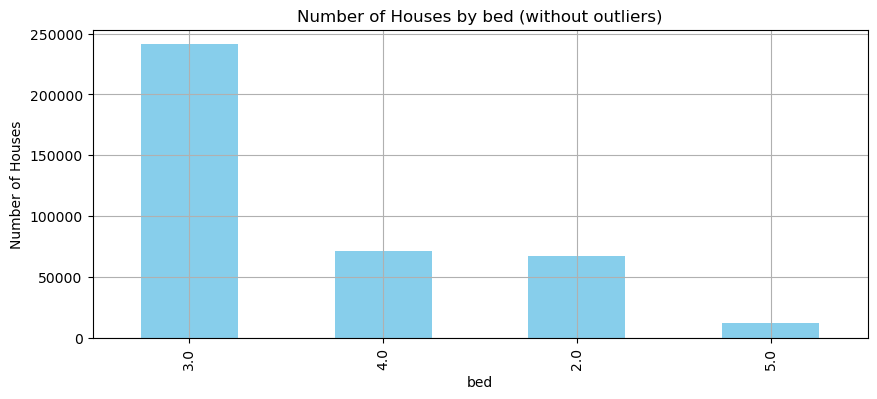

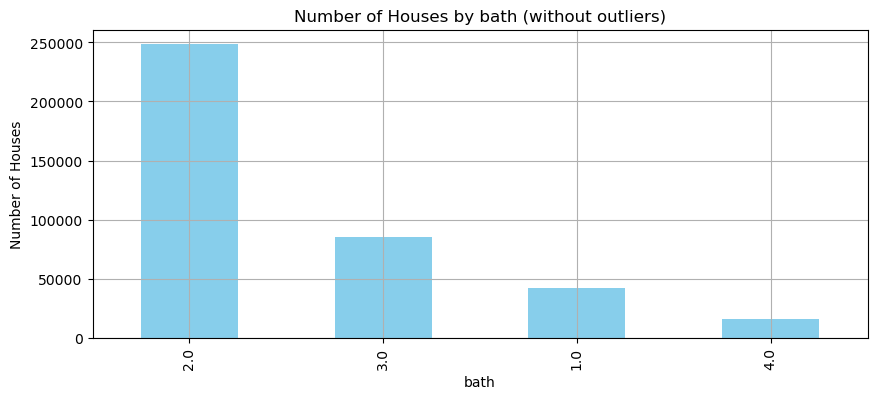

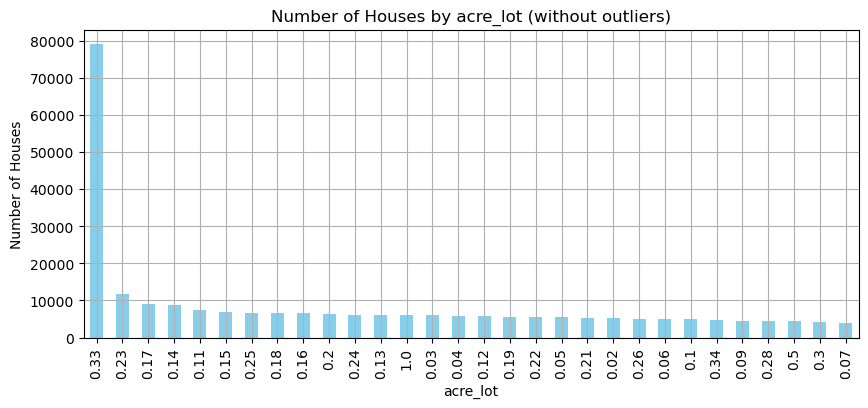

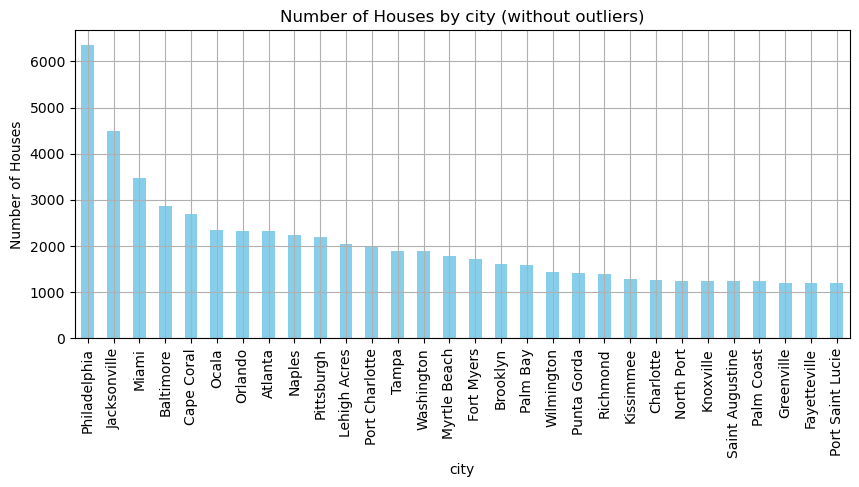

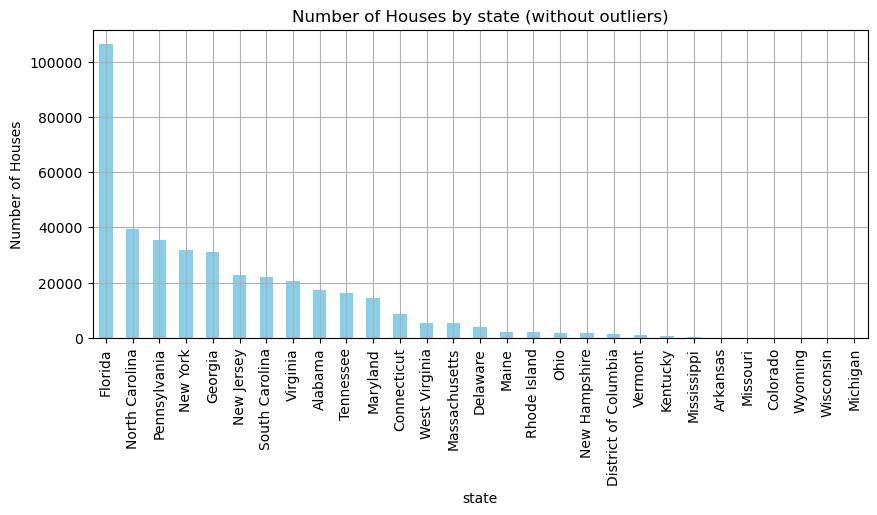

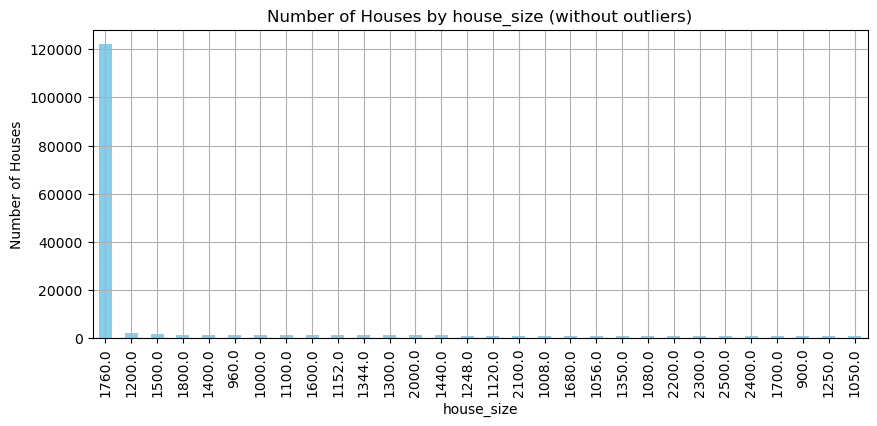

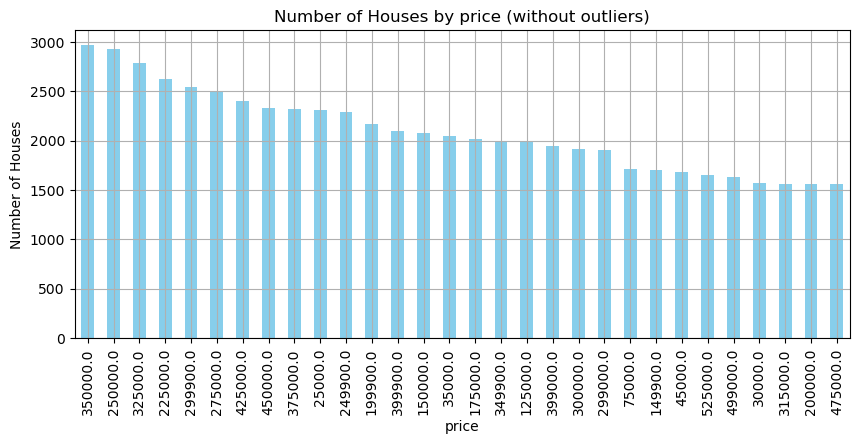

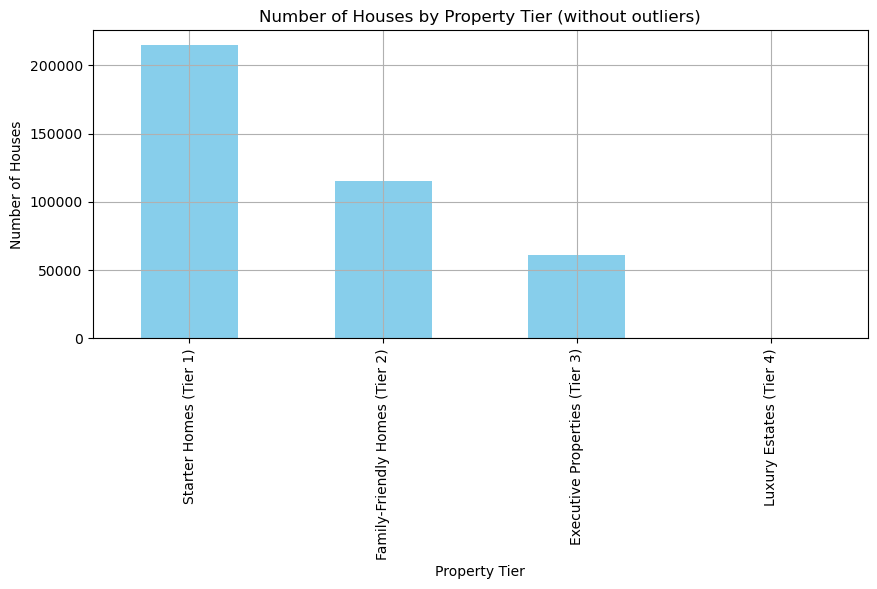

In [86]:
# Plot bar graph for each column (for data frame without outliers)
for col in df.columns:
    # Pick top 30 unique counts for bar chart
    df_no_outliers[col].value_counts().head(30).plot(kind='bar', figsize=(10,4), color='skyblue')

    # Set title, labels and display
    plt.title(f'Number of Houses by {col} (without outliers)')
    plt.xlabel(col)
    plt.ylabel('Number of Houses')
    plt.grid(True)
    plt.show()

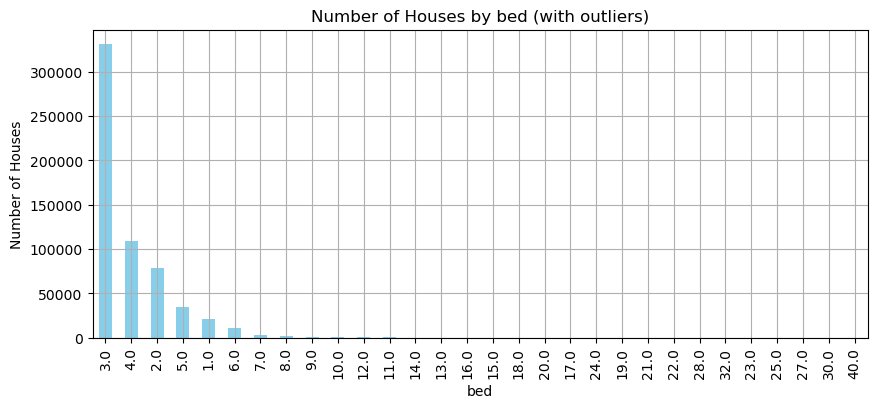

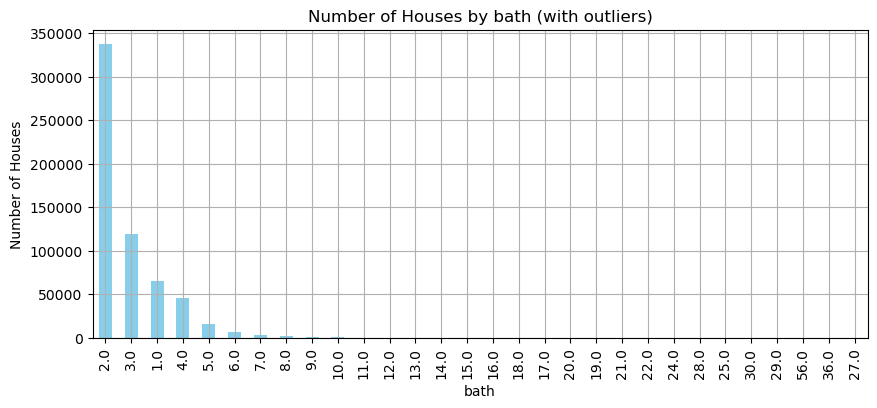

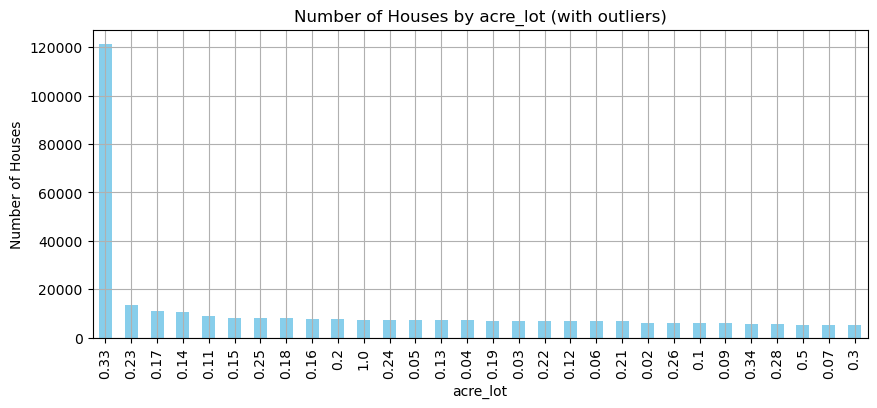

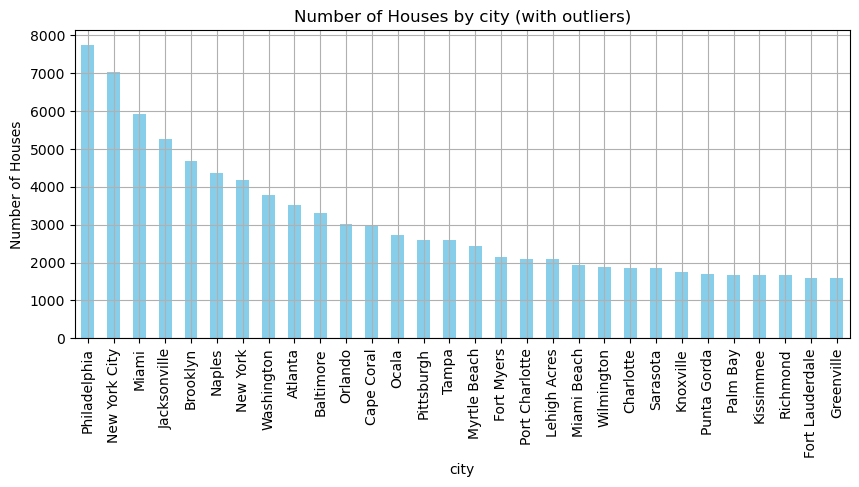

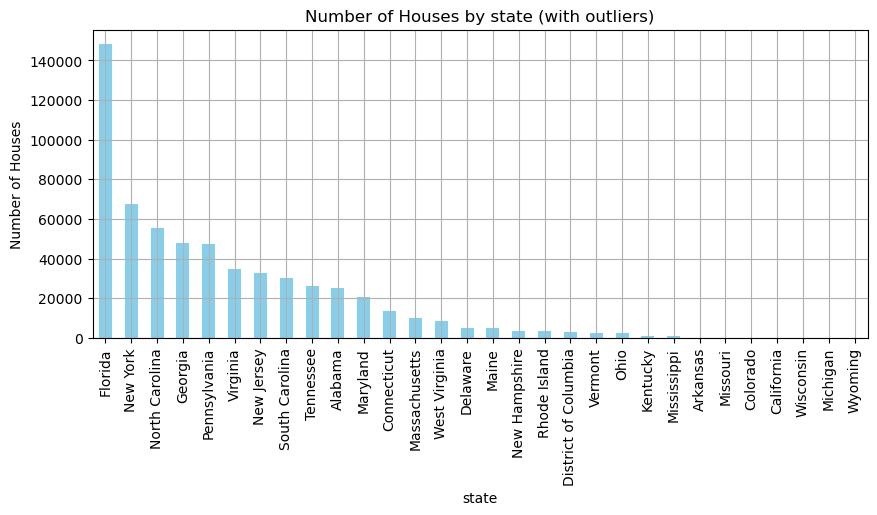

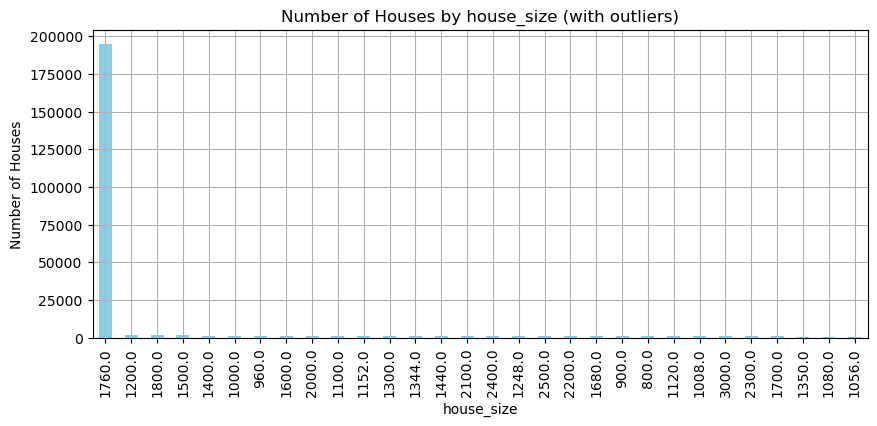

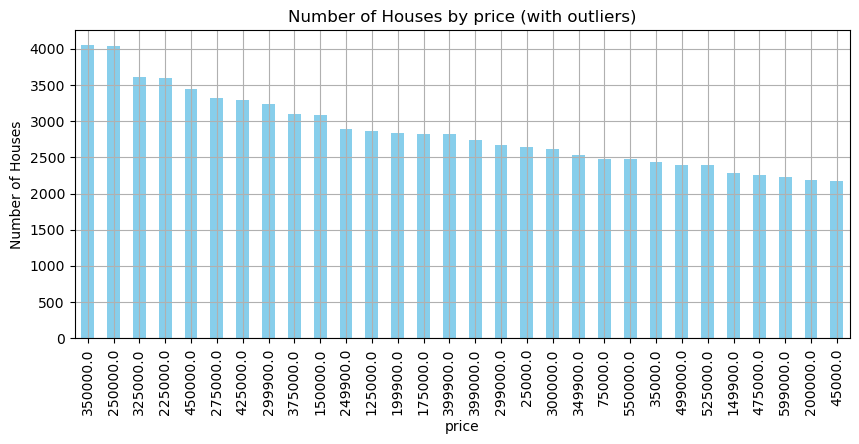

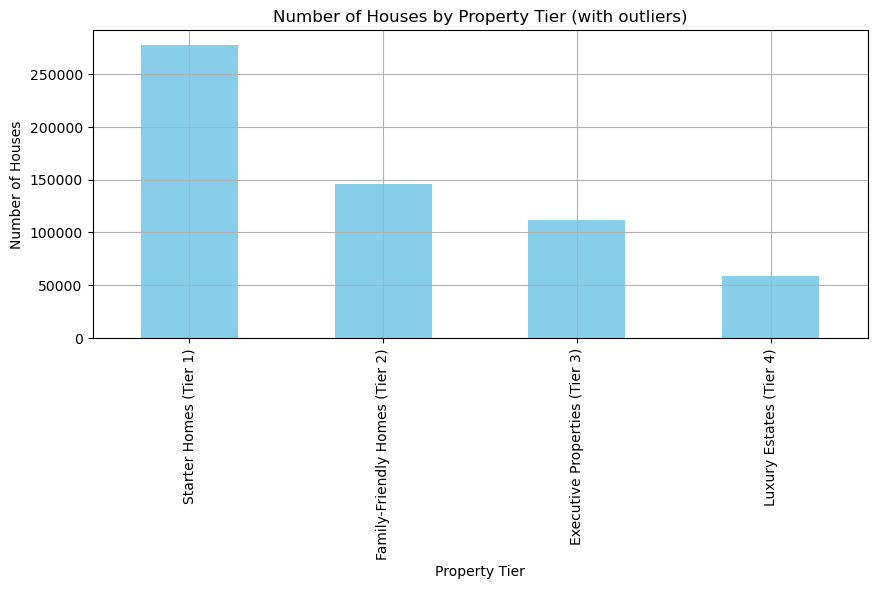

In [88]:
# Plot bar graph for each column (for data frame with outliers)
for col in df.columns:
    # Pick top 30 unique counts for bar chart
    df_filtered[col].value_counts().head(30).plot(kind='bar', figsize=(10,4), color='skyblue')

    # Set title, labels and display
    plt.title(f'Number of Houses by {col} (with outliers)')
    plt.xlabel(col)
    plt.ylabel('Number of Houses')
    plt.grid(True)
    plt.show()

In [89]:
# Group by state, city, bed and bath
# Display mean values for acre_lot, house_size and price
print('Group by state, city, bed and bath for dataframe without outliers')
df_no_outliers.groupby(['state', 'city', 'bed', 'bath']).agg({'acre_lot' : 'mean', 'house_size' : 'mean', 'price' : 'mean'})

Group by state, city, bed and bath for dataframe without outliers


acre_lot   house_size          price
state         city           bed bath                                      
Alabama       Abbeville      2.0 1.0   0.665000  1041.500000   81500.000000
                                 2.0   0.715000  1111.000000  111700.000000
                             3.0 1.0   0.290000   970.000000   33494.000000
                                 2.0   0.613265  1734.367347  102894.897959
                             4.0 2.0   0.476667  1818.000000  364833.333333
...                                         ...          ...            ...
West Virginia Winifrede      3.0 2.0   0.600000  1424.000000  129900.000000
              Wyoming        4.0 2.0   0.170000  1860.000000   62500.000000
              Yellow Spring  3.0 2.0   1.000000  1200.000000  249900.000000
Wisconsin     Baileys Harbor 2.0 2.0   0.330000  1144.000000  429900.000000
Wyoming       Cody           3.0 3.0   0.290000  1935.000000  535000.000000

[45300 rows x 3 columns]

In [90]:
# Group by state, city, bed and bath
# Display mean values for acre_lot, house_size and price
print('Group by state, city, bed and bath for dataframe with outliers')
df_filtered.groupby(['state', 'city', 'bed', 'bath']).agg({'acre_lot' : 'mean', 'house_size' : 'mean', 'price' : 'mean'})

Group by state, city, bed and bath for dataframe with outliers


acre_lot   house_size          price
state         city           bed bath                                       
Alabama       Abbeville      1.0 1.0    0.500000   700.000000   14500.000000
                                 2.0    1.000000   659.000000  295000.000000
                             2.0 1.0    0.616667   887.666667  179333.333333
                                 2.0    0.715000  1111.000000  111700.000000
                             3.0 1.0    1.563333  1136.666667  152296.000000
...                                          ...          ...            ...
West Virginia Wyoming        4.0 2.0    0.170000  1860.000000   62500.000000
              Yellow Spring  2.0 1.0    9.830000   768.000000  275000.000000
                             3.0 2.0   10.505000  1480.000000  179450.000000
Wisconsin     Baileys Harbor 2.0 2.0    0.330000  1144.000000  429900.000000
Wyoming       Cody           3.0 3.0    0.290000  1935.000000  535000.000000

[79575 rows x 3 columns]

In [91]:
# Counts of unique values in descending order for price_tier (for dataframe without outliers)
df_no_outliers['Property Tier'].value_counts()

Property Tier
Starter Homes (Tier 1)            215093
Family-Friendly Homes (Tier 2)    115002
Executive Properties (Tier 3)      61055
Luxury Estates (Tier 4)                0
Name: count, dtype: int64

In [92]:
# Counts of unique values in descending order for price_tier (for dataframe with outliers)
df_filtered['Property Tier'].value_counts()

Property Tier
Starter Homes (Tier 1)            277773
Family-Friendly Homes (Tier 2)    146286
Executive Properties (Tier 3)     111867
Luxury Estates (Tier 4)            58599
Name: count, dtype: int64

Property Tier  Starter Homes (Tier 1)  Family-Friendly Homes (Tier 2)  \
bed bath                                                                
2.0 1.0                       14573.0                          3247.0   
    2.0                       22329.0                         11515.0   
    3.0                        2388.0                          2364.0   
    4.0                          81.0                           154.0   
3.0 1.0                       16215.0                          2872.0   
    2.0                      126996.0                         36053.0   
    3.0                       10224.0                         18412.0   
    4.0                         482.0                          2152.0   
4.0 1.0                        1829.0                           383.0   
    2.0                       11386.0                         11833.0   
    3.0                        5091.0                         17796.0   
    4.0                         562.0              

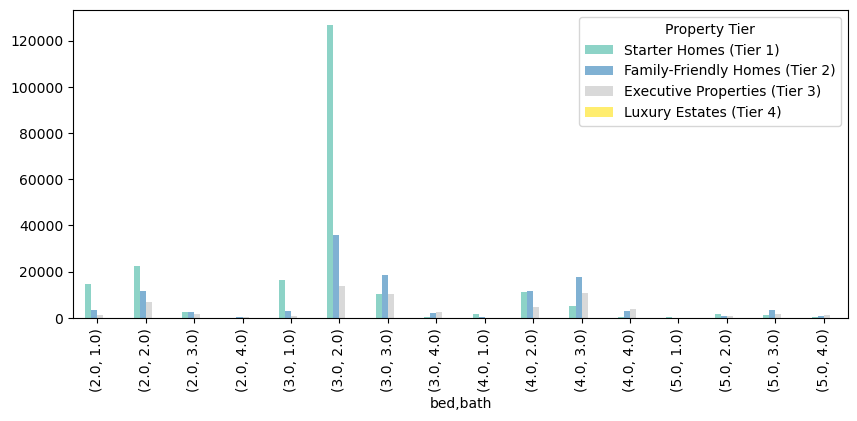

In [93]:
# Plot distribution of price tier by number of beds and baths (for dataframe without outliers)

# Group data by bed, bath and price tier
grouped = df_no_outliers.groupby(['bed', 'bath', 'Property Tier'], observed=False).size().reset_index(name='count')

# Create and print pivot table
pivot_table = pd.pivot_table(grouped, values='count', index=['bed', 'bath'], columns=['Property Tier'])
print(pivot_table)

# Plot bar chart for pivot table
pivot_table.plot(kind='bar', figsize=(10,4), colormap='Set3')
plt.show()

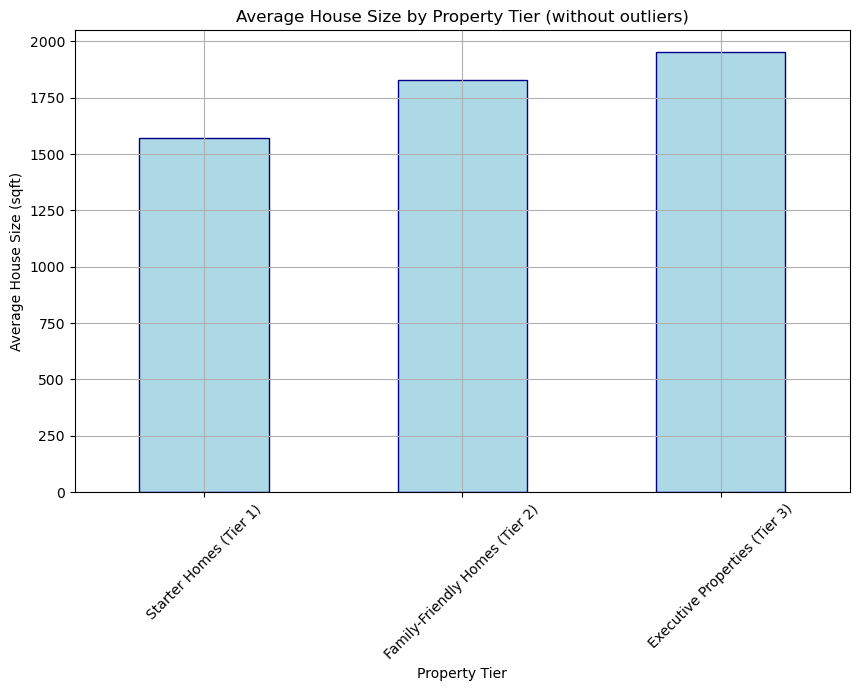

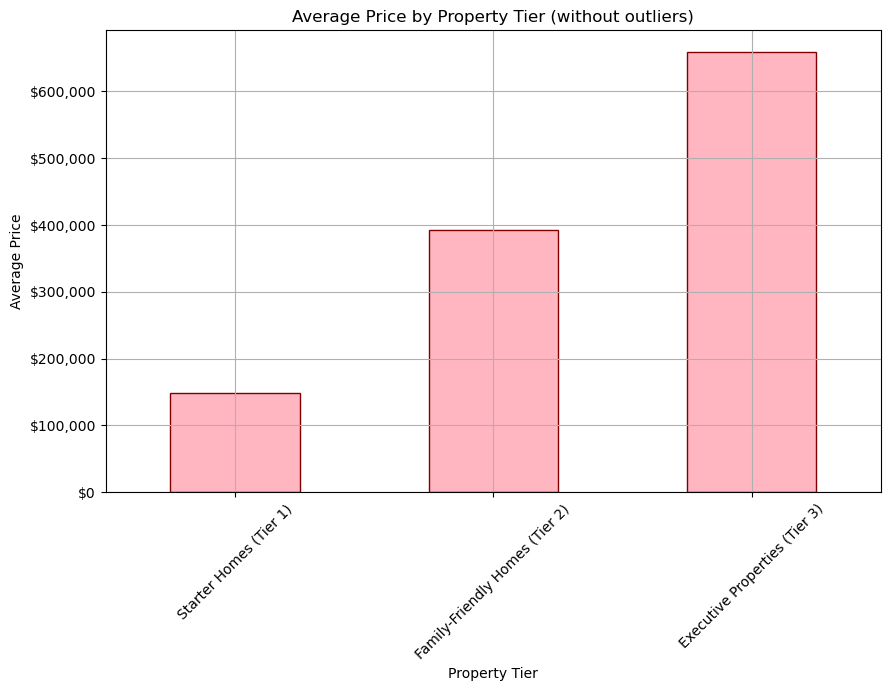

In [95]:
# Plot distribution of properties by property tier (for dataframe without outliers)
plt.figure(figsize=(10, 6))
df_no_outliers.groupby('Property Tier', observed=True)['house_size'].mean().sort_index().plot(kind='bar', color='lightblue', edgecolor='darkblue')
plt.title('Average House Size by Property Tier (without outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average House Size (sqft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot average price by property tier (for dataframe without outliers)
plt.figure(figsize=(10, 6))
ax = df_no_outliers.groupby('Property Tier', observed=True)['price'].mean().sort_index().plot(kind='bar', color='lightpink', edgecolor='maroon')
plt.title('Average Price by Property Tier (without outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)

# Format y-axis labels as dollar amounts
formatter = '${x:,.0f}'
ax.yaxis.set_major_formatter(formatter)

plt.show()

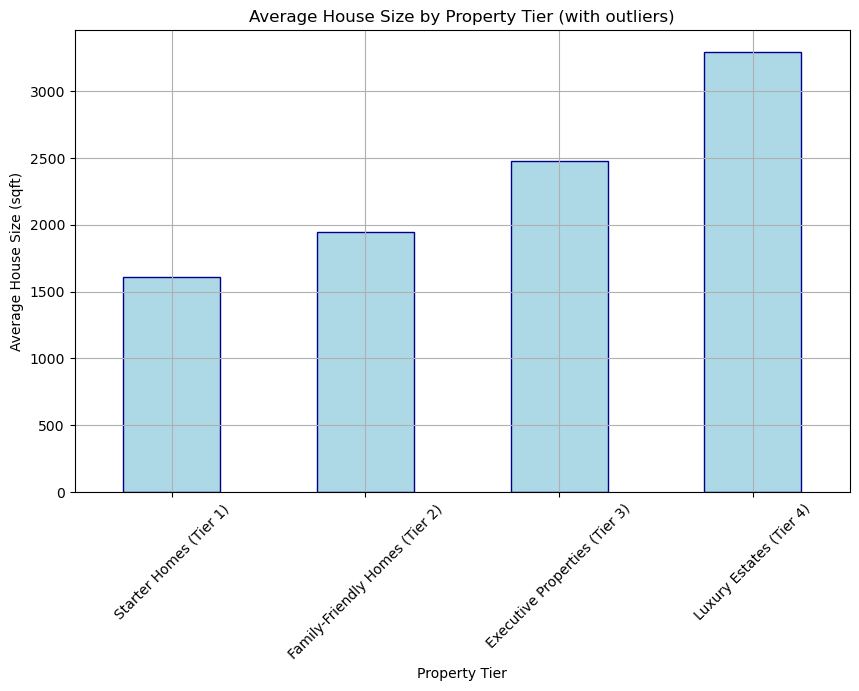

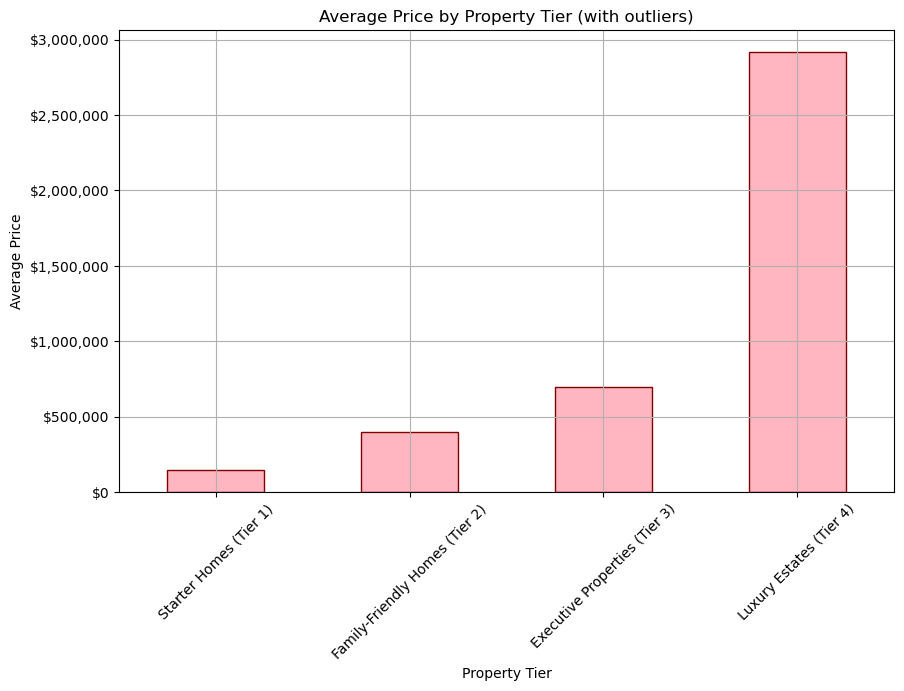

In [96]:
# Plot distribution of properties by property tier (for dataframe with outliers)
plt.figure(figsize=(10, 6))
df_filtered.groupby('Property Tier', observed=True)['house_size'].mean().sort_index().plot(kind='bar', color='lightblue', edgecolor='darkblue')
plt.title('Average House Size by Property Tier (with outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average House Size (sqft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot average price by property tier (for dataframe with outliers)
plt.figure(figsize=(10, 6))
ax = df_filtered.groupby('Property Tier', observed=True)['price'].mean().sort_index().plot(kind='bar', color='lightpink', edgecolor='maroon')
plt.title('Average Price by Property Tier (with outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)

# Format y-axis labels as dollar amounts
formatter = '${x:,.0f}'
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Inferential Statistics

In [99]:
# Columns for Chi-Square test
columns_for_chi2 = numerical_columns + categorical_columns

# Create a contingency table for each column
contingency_tables = {}
for col in columns_for_chi2:
    contingency_tables[col] = pd.crosstab(df_filtered[col], df_filtered['Property Tier'])

# Perform Chi-Square tests
alpha = 0.05
significant_results = {}
for col, table in contingency_tables.items():
    chi2, p_value, _, _ = chi2_contingency(table)
    significant_results[col] = p_value < alpha

# Print results
for col, significant in significant_results.items():
    if significant:
        print(f"Chi-Square test for {col}: Significant association (reject null hypothesis) - Property Tier and {col} are associated.")
    else:
        print(f"Chi-Square test for {col}: No significant association (fail to reject null hypothesis) - Property Tier and {col} are independent.")


Chi-Square test for bed: Significant association (reject null hypothesis) - Property Tier and bed are associated.
Chi-Square test for bath: Significant association (reject null hypothesis) - Property Tier and bath are associated.
Chi-Square test for acre_lot: Significant association (reject null hypothesis) - Property Tier and acre_lot are associated.
Chi-Square test for house_size: Significant association (reject null hypothesis) - Property Tier and house_size are associated.
Chi-Square test for price: Significant association (reject null hypothesis) - Property Tier and price are associated.
Chi-Square test for city: Significant association (reject null hypothesis) - Property Tier and city are associated.
Chi-Square test for state: Significant association (reject null hypothesis) - Property Tier and state are associated.


## Model Selection and Analysis

### Feature Selection and Splitting Data

In [104]:
# Drop rows with missing target values
df = df.dropna(subset=['price'])

# Separate features (X) and target variable (y)
X = data.drop('price', axis=1)  # Assuming 'price' is the target variable
y = data['price']

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Apply one-hot encoding to categorical features and concatenate with numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', SimpleImputer(strategy='mean'), numerical_features)
    ],
    remainder='passthrough'
)
X_encoded = preprocessor.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features
X_train_selected = selector.fit_transform(X_train, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get selected feature names
selected_cat_features = preprocessor.transformers_[0][1].get_feature_names_out(input_features=categorical_features)
selected_features = np.concatenate([selected_cat_features, numerical_features, ])

print("Selected Features:", selected_features)

Selected Features: ['city_100 89 Lower Shepard Creek Road' 'city_21 27 Tommie Lane'
 'city_Aaronsburg' ... 'bath' 'acre_lot' 'house_size']


### Linear Regression Model

In [105]:
# Train a model on selected features
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Transform test set with selected features
X_test_selected = X_test[:, selected_feature_indices]

# Make predictions
y_pred = model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

### Next Model